ライブラリのインポートが完了しました。
CuPyがGPUを利用していることを確認: True

論文掲載用のプロットスタイルが適用されました。
3D温度スイープ実験を開始します。
測定する温度点: [0.001, 0.1, 1.0]

--- シミュレーション開始: T = 0.001 ---
--- シミュレーション完了: T = 0.001 (所要時間: 302.72 秒) ---
  - 結果: Gain = 3.1274e-06, Phase = -81.66°, Coherence = 0.0328
  - 生データを '3d_ol_T0.001_A1.0_omega0.2_raw.csv' として保存しました。

--- シミュレーション開始: T = 0.100 ---
--- シミュレーション完了: T = 0.100 (所要時間: 298.39 秒) ---
  - 結果: Gain = 2.1817e-07, Phase = 146.01°, Coherence = 0.0073
  - 生データを '3d_ol_T0.1_A1.0_omega0.2_raw.csv' として保存しました。

--- シミュレーション開始: T = 1.000 ---
--- シミュレーション完了: T = 1.000 (所要時間: 297.70 秒) ---
  - 結果: Gain = 2.4351e-07, Phase = 60.21°, Coherence = 0.0000
  - 生データを '3d_ol_T1.0_A1.0_omega0.2_raw.csv' として保存しました。

全てのシミュレーションが完了しました。

【3D温度スイープ実験 結果サマリー】
   Temperature      Gain |N|  Phase ∠N (deg)  Coherence
0        0.001  3.127388e-06      -81.660259   0.032791
1        0.100  2.181737e-07      146.014658   0.007250
2        1.000  2.435090e-07       60.206334   0.000004

結果サマリーを 'M2_summary_3D_g

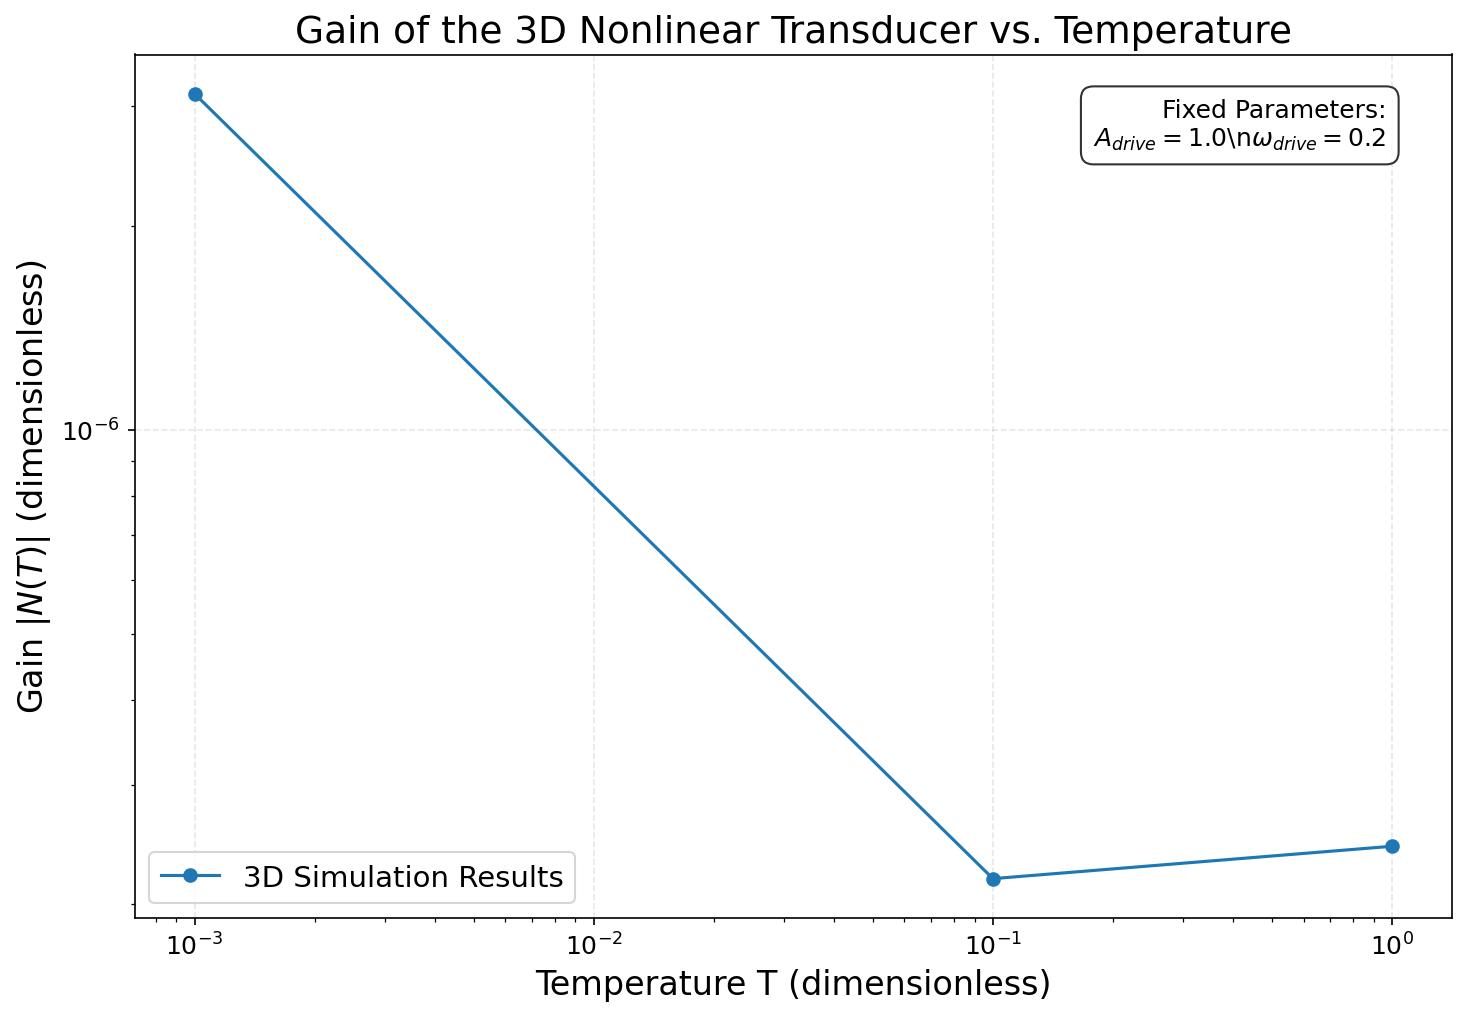


【成果物の保存に関するご確認】

1. Google Colabノートブック（.ipynbファイル）について:
   - 対象ファイル: M2_04_3D_Temperature_Sweep_v1.ipynb
   - 指示: このノートブックを、以下のフォルダに「新規保存」してください。
   - 保存先フォルダ: CoupledFieldD3D_Research_V7_20250828/01_src/simulator/

2. 生成されたデータファイル（.csvファイル）について:
   - 対象ファイル 1: M2_summary_3D_gain_vs_temp.csv
   - 指示: Colabからこのファイルをダウンロードし、以下のフォルダに保存してください。
   - 保存先フォルダ: CoupledFieldD3D_Research_V7_20250828/03_results/tables/

   - 対象ファイル 2: ol_T0.001_..._raw.csv, ol_T0.1_..._raw.csv, ol_T1.0_..._raw.csv (計3ファイル)
   - 指示: Colabからこれらのファイルをダウンロードし、以下のフォルダに保存してください。
   - 保存先フォルダ: CoupledFieldD3D_Research_V7_20250828/02_data/M2_3D_Core/open_loop/

3. 生成されたビジュアル画像データ（.pdfファイル）について:
   - 対象ファイル: M2_Fig2_3D_Gain_vs_Temperature_EN.pdf
   - 指示: Colabからこのファイルをダウンロードし、以下のフォルダに保存してください。
   - 保存先フォルダ: CoupledFieldD3D_Research_V7_20250828/03_results/figures/M2_3D_Core/


In [1]:
# =============================================================================
# M2_04_3D_Temperature_Sweep_v1.ipynb
#
# 目的:
# 3次元空間において、系の応答が温度Tにどのように依存するかを測定する
# 「3D温度スイープ」実験を、データ生成から最終成果物の保存まで一気通貫で実行する。
#
# このノートブックは、M2マイルストーンの科学的目標を達成するための核心的な実験である。
# =============================================================================

# === セル 1: ライブラリのインポート ===
import cupy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.signal import coherence
from scipy.integrate import trapezoid
import time

print("ライブラリのインポートが完了しました。")
print(f"CuPyがGPUを利用していることを確認: {cp.is_available()}")

# --- 2. 論文掲載用のプロットスタイルガイドを定義 (英語表記・フォント埋め込み) ---
plot_style_en = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica', 'Arial', 'DejaVu Sans'],
    'font.size': 14, 'axes.labelsize': 16, 'axes.titlesize': 18,
    'xtick.labelsize': 12, 'ytick.labelsize': 12, 'legend.fontsize': 14,
    'figure.figsize': (10, 7), 'figure.dpi': 150,
    'axes.grid': True, 'grid.alpha': 0.3, 'grid.linestyle': '--',
    'pdf.fonttype': 42, 'ps.fonttype': 42
}
plt.rcParams.update(plot_style_en)
print("\n論文掲載用のプロットスタイルが適用されました。")


# --- 3. 3Dシミュレーションと解析のコア機能を関数化 ---
def run_3d_simulation_and_analysis(temperature, base_params):
    """指定された温度で3Dシミュレーションと解析を実行し、結果と生データを返す関数"""

    params = base_params.copy()
    params['T'] = temperature

    dx = params['Lx'] / params['Nx']; dy = params['Ly'] / params['Ny']; dz = params['Lz'] / params['Nz']
    x = cp.arange(-params['Lx']/2, params['Lx']/2, dx); y = cp.arange(-params['Ly']/2, params['Ly']/2, dy); z = cp.arange(-params['Lz']/2, params['Lz']/2, dz)
    X, Y, Z = cp.meshgrid(x, y, z, indexing='ij')
    kx = 2 * np.pi * cp.fft.fftfreq(params['Nx'], d=dx); ky = 2 * np.pi * cp.fft.fftfreq(params['Ny'], d=dy); kz = 2 * np.pi * cp.fft.fftfreq(params['Nz'], d=dz)
    Kx, Ky, Kz = cp.meshgrid(kx, ky, kz, indexing='ij'); K_squared = Kx**2 + Ky**2 + Kz**2
    k_nyquist = cp.pi / max(dx, dy, dz); k_c = params['k_c_ratio'] * k_nyquist
    projection_mask = cp.array(K_squared < k_c**2, dtype=int)
    sigma_psi = 10.0; psi0 = cp.exp(-(X**2 + Y**2 + Z**2) / (2 * sigma_psi**2))
    norm_factor = cp.sqrt(cp.sum(cp.abs(psi0)**2) * dx * dy * dz); psi = psi0 / norm_factor
    def calculate_potential_3d(X, Y, Z, z_b, params): V = params['V0'] * cp.exp(-((Z - z_b)**2 / (2 * params['sigma_z']**2))); return V
    def calculate_feedback_force_3d(psi, X, Y, Z, z_b, params, dx, dy, dz): psi_density = cp.abs(psi)**2; dV_dz = -((Z - z_b) / (params['sigma_z']**2)) * calculate_potential_3d(X, Y, Z, z_b, params); force = cp.sum(psi_density * dV_dz) * dx * dy * dz; return force

    psi_current = cp.copy(psi); num_record_steps = params['total_steps'] - params['transient_steps']; t_history = np.zeros(num_record_steps); z_b_history = np.zeros(num_record_steps); F_fb_history = np.zeros(num_record_steps); record_idx = 0
    for step in range(params['total_steps']):
        current_time = (step + 1) * params['dt']; z_b = params['A_drive'] * cp.sin(params['omega_drive'] * current_time); V = calculate_potential_3d(X, Y, Z, z_b, params); real_space_H_psi = (V + params['g_3D'] * cp.abs(psi_current)**2) * psi_current; drift_term = - (1j + params['gamma']) * (real_space_H_psi - params['mu'] * psi_current); projected_drift_term = cp.fft.ifftn(projection_mask * cp.fft.fftn(drift_term)); psi_half_step = psi_current + projected_drift_term * params['dt'] / 2.0; psi_k = cp.fft.fftn(psi_half_step); psi_k = cp.exp(-0.5j * K_squared * params['dt']) * psi_k; psi_full_kinetic = cp.fft.ifftn(psi_k); V = calculate_potential_3d(X, Y, Z, z_b, params); real_space_H_psi = (V + params['g_3D'] * cp.abs(psi_full_kinetic)**2) * psi_full_kinetic; drift_term = - (1j + params['gamma']) * (real_space_H_psi - params['mu'] * psi_full_kinetic); projected_drift_term = cp.fft.ifftn(projection_mask * cp.fft.fftn(drift_term)); psi_deterministic = psi_full_kinetic + projected_drift_term * params['dt'] / 2.0; dW = (cp.random.randn(*psi.shape) + 1j * cp.random.randn(*psi.shape)) / cp.sqrt(2.0) * cp.sqrt(params['dt'] / (dx * dy * dz)); projected_noise = cp.fft.ifftn(projection_mask * cp.fft.fftn(dW)); psi_current = psi_deterministic + cp.sqrt(2 * params['gamma'] * params['T']) * projected_noise; current_norm = cp.sqrt(cp.sum(cp.abs(psi_current)**2) * dx * dy * dz); psi_current = psi_current / current_norm
        if step >= params['transient_steps']: F_fb = calculate_feedback_force_3d(psi_current, X, Y, Z, z_b, params, dx, dy, dz); t_history[record_idx] = current_time; z_b_history[record_idx] = z_b.item(); F_fb_history[record_idx] = F_fb.item(); record_idx += 1

    t = t_history; zb = z_b_history; Ffb = F_fb_history; ref_signal = np.exp(-1j * params['omega_drive'] * t); integral_val = trapezoid(Ffb * ref_signal, t); T_w = t[-1] - t[0]; C_1omega = (2 / T_w) * integral_val; N_complex = C_1omega / params['A_drive']; N_gain = np.abs(N_complex); N_phase_deg = np.rad2deg(np.angle(N_complex)); fs = 1 / params['dt']; nperseg = 8192; f_coh, Cxy = coherence(zb, Ffb, fs=fs, nperseg=nperseg); omega_coh = 2 * np.pi * f_coh; coh_at_drive_freq = Cxy[np.argmin(np.abs(omega_coh - params['omega_drive']))]

    return N_gain, N_phase_deg, coh_at_drive_freq, t_history, z_b_history, F_fb_history


# --- 4. メイン実行ブロック ---
base_params = {
    'g_3D': -0.3, 'gamma': 0.1, 'mu': 0.0,
    'V0': 0.1, 'sigma_z': 4.0, 'A_drive': 1.0, 'omega_drive': 0.2,
    'Nx': 64, 'Ny': 64, 'Nz': 64,
    'Lx': 100.0, 'Ly': 100.0, 'Lz': 100.0,
    'dt': 1e-3, 'total_steps': 100000, 'k_c_ratio': 0.7,
    'transient_steps': 2000
}
temperatures_to_sweep = [0.001, 0.1, 1.0]
results = []

print("3D温度スイープ実験を開始します。")
print(f"測定する温度点: {temperatures_to_sweep}")

for temp in temperatures_to_sweep:
    start_time = time.time()
    print("\n" + "="*50)
    print(f"--- シミュレーション開始: T = {temp:.3f} ---")

    gain, phase, coh_value, t, zb, Ffb = run_3d_simulation_and_analysis(temp, base_params)

    results.append({'Temperature': temp, 'Gain |N|': gain, 'Phase ∠N (deg)': phase, 'Coherence': coh_value})

    end_time = time.time()
    print(f"--- シミュレーション完了: T = {temp:.3f} (所要時間: {end_time - start_time:.2f} 秒) ---")
    print(f"  - 結果: Gain = {gain:.4e}, Phase = {phase:.2f}°, Coherence = {coh_value:.4f}")

    df_temp = pd.DataFrame({'time': t, 'zb_drive': zb, 'F_feedback': Ffb})
    csv_filename = f"3d_ol_T{temp}_A{base_params['A_drive']}_omega{base_params['omega_drive']}_raw.csv"
    df_temp.to_csv(csv_filename, index=False)
    print(f"  - 生データを '{csv_filename}' として保存しました。")

print("\n" + "="*50)
print("全てのシミュレーションが完了しました。")

results_df = pd.DataFrame(results)
print("\n【3D温度スイープ実験 結果サマリー】")
print(results_df)

summary_csv_filename = "M2_summary_3D_gain_vs_temp.csv"
results_df.to_csv(summary_csv_filename, index=False)
print(f"\n結果サマリーを '{summary_csv_filename}' として保存しました。")


# --- 5. 最終プロットの生成とPDF保存 ---
fig, ax = plt.subplots(figsize=plot_style_en['figure.figsize'])
ax.plot(results_df['Temperature'], results_df['Gain |N|'], marker='o', linestyle='-', label='3D Simulation Results')
ax.set_xlabel('Temperature T (dimensionless)'); ax.set_ylabel(r'Gain $|N(T)|$ (dimensionless)')
ax.set_title('Gain of the 3D Nonlinear Transducer vs. Temperature')
ax.set_xscale('log'); ax.set_yscale('log')
ax.legend()
param_text = (f"Fixed Parameters:\n" fr"$A_{{drive}} = {base_params['A_drive']}$\n" fr"$\omega_{{drive}} = {base_params['omega_drive']}$")
ax.text(0.95, 0.95, param_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))
plt.tight_layout()

pdf_filename = "M2_Fig2_3D_Gain_vs_Temperature_EN.pdf"
plt.savefig(pdf_filename, bbox_inches='tight')
print(f"最終プロットを '{pdf_filename}' として保存しました。")
plt.show()


# --- 6. 保存手順の最終確認明示 ---
print("\n" + "="*60)
print("【成果物の保存に関するご確認】")
print("\n1. Google Colabノートブック（.ipynbファイル）について:")
print(f"   - 対象ファイル: M2_04_3D_Temperature_Sweep_v1.ipynb")
print(f"   - 指示: このノートブックを、以下のフォルダに「新規保存」してください。")
print(f"   - 保存先フォルダ: CoupledFieldD3D_Research_V7_20250828/01_src/simulator/")
print("\n2. 生成されたデータファイル（.csvファイル）について:")
print(f"   - 対象ファイル 1: {summary_csv_filename}")
print(f"   - 指示: Colabからこのファイルをダウンロードし、以下のフォルダに保存してください。")
print(f"   - 保存先フォルダ: CoupledFieldD3D_Research_V7_20250828/03_results/tables/")
print(f"\n   - 対象ファイル 2: ol_T0.001_..._raw.csv, ol_T0.1_..._raw.csv, ol_T1.0_..._raw.csv (計3ファイル)")
print(f"   - 指示: Colabからこれらのファイルをダウンロードし、以下のフォルダに保存してください。")
print(f"   - 保存先フォルダ: CoupledFieldD3D_Research_V7_20250828/02_data/M2_3D_Core/open_loop/")
print("\n3. 生成されたビジュアル画像データ（.pdfファイル）について:")
print(f"   - 対象ファイル: {pdf_filename}")
print(f"   - 指示: Colabからこのファイルをダウンロードし、以下のフォルダに保存してください。")
print(f"   - 保存先フォルダ: CoupledFieldD3D_Research_V7_20250828/03_results/figures/M2_3D_Core/")
print("="*60)